In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from PIL import Image
import os

from sklearn.model_selection import train_test_split, KFold

# Using Raw image

In [2]:
def load_images(path=None, resize=(500, 500)):
    if path is None:
        path = os.path.join(os.getcwd(), 'images')

    images = []
    students = []

    for student in os.listdir(path):
        student_path = os.path.join(path, student)
        
        if os.path.isdir(student_path):
        
            for image in os.listdir(student_path):
                image_path = os.path.join(student_path, image)
        
                if os.path.isfile(image_path):
                    image = Image.open(image_path)
                    image = image.convert('L')
                    
                    if image.size != resize:
                        image = image.resize(resize)
                    
                    image_vector = np.array(image, dtype=np.float64).flatten()                    
                        
                    images.append(image_vector)
                    students.append(student)
    
    return np.array(images), np.array(students)

In [3]:
def draw(vec, imsize=(500, 500)):
    plt.imshow(vec.reshape(imsize), cmap='gray')

In [4]:
def calculate_pca(X, num_components):
    n, _ = X.shape
    
    num_components = min(num_components, n)
    
    mean = np.mean(X, axis=0)
    
    centered_data = (X - mean)    
        
    L = np.dot(centered_data, centered_data.T)
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    eigenvectors = np.dot(centered_data.T , eigenvectors)

    for i in range(n):
        eigenvectors [: , i] = eigenvectors [: , i] / np.linalg.norm(eigenvectors [: , i])        
    
    idx = np.argsort(-eigenvalues)    
    eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]
    
    return eigenvalues[:num_components], eigenvectors[:, :num_components], mean

In [5]:
def project(W, X, mean):          
    return np.dot(X  - mean, W)

In [6]:
def reconstruct(W, Y):
    return np.dot(Y, W.T)

In [7]:
def compute_threshold(projections):
    n = len(projections)
    
    max_dist = float('-inf')
    
    for i in range(n):        
        for j in range(i+1, n):            
            dist = np.linalg.norm(projections[i] - projections[j])
            max_dist = max(max_dist, dist)
    
    return max_dist / 2

In [8]:
def closest_face(projections, labels, p):          
    distances = [np.linalg.norm(p - pi) for pi in projections]    
    
    sorted_distances_idx = np.argsort(distances)
    
    return labels[sorted_distances_idx[0]], distances[sorted_distances_idx[0]]

In [9]:
def predict(X, eigenvectors, projections, labels, meanface, threshold):
    y_pred = []

    
    for image in X:
        image = image.reshape(1, -1)
        
        p = project(eigenvectors, image, meanface)
        
        prediction, dist = closest_face(projections, labels, p)
        
        reconstructed = reconstruct(eigenvectors, p)
        
        rec_dist = np.linalg.norm((image - meanface) - reconstructed)  
        rec_threshold = threshold * 1.43   
          
        # print(rec_dist, dist, threshold)

        if rec_dist >= threshold and dist > rec_threshold:
            y_pred.append('NotFace')
        
        elif dist >= threshold:            
            y_pred.append('NewFace')
        
        else:
            y_pred.append(prediction)
    
    return np.array(y_pred)

In [10]:
images, students = load_images()

KeyboardInterrupt: 

In [ ]:
images.shape, students.shape

((529, 250000), (529,))

In [41]:
x_train, x_test, y_train, y_test = train_test_split(images, students, test_size=0.2, random_state=42, stratify=students)

In [42]:
num_components = 100

eigenvalues, eigenvectors, mean_face = calculate_pca(x_train, num_components)

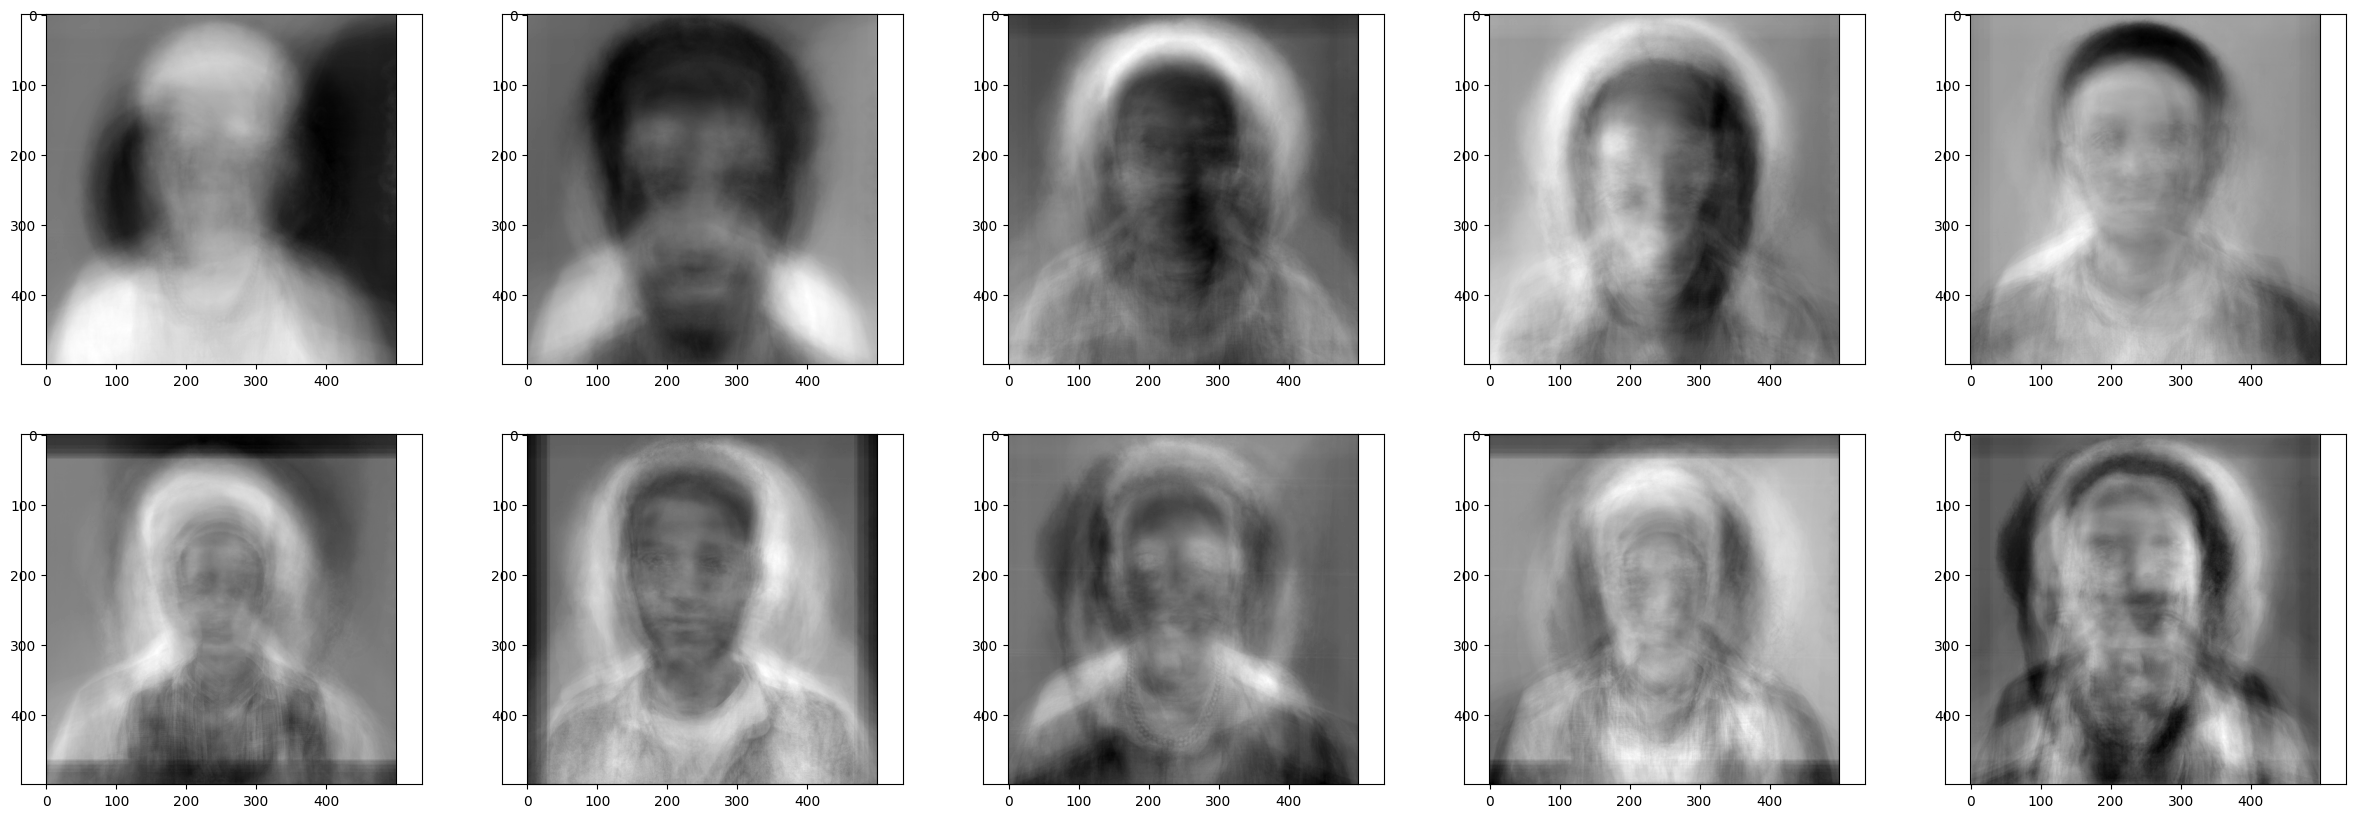

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, face in enumerate(eigenvectors.T[:10]):    
    fig.add_subplot(2, 5, i + 1)
    draw(face)

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

In [44]:
projections = []

for image in x_train:
    projections.append(project(eigenvectors, image.reshape(1, -1), mean_face))

projections = np.array(projections)

In [45]:
threshold = compute_threshold(projections)

In [10]:
def confusion_matrix(expected, predicted, classes):        
    c_idx = {cls: idx for idx, cls in enumerate(classes)}
        
    n = len(classes)
    
    cm = np.zeros((n, n))
    
    for y, y_pred in zip(expected, predicted):
        if y in c_idx and y_pred in c_idx:
            idx_y = c_idx[y]
            idx_pred = c_idx[y_pred]

            cm[idx_y][idx_pred] += 1
    
    return cm

In [11]:
def calc_accuracy(expected, predicted):
    return np.sum(expected.flatten() == predicted.flatten()) / len(expected)

In [48]:
y_pred = predict(x_test,
                 eigenvectors,
                 projections,
                 labels = y_train,
                 meanface = mean_face,
                 threshold = threshold)

In [49]:
student_names = np.unique(np.concatenate((y_train, ['NotFace', 'NewFace'])))
cm = confusion_matrix(y_test, y_pred, student_names)

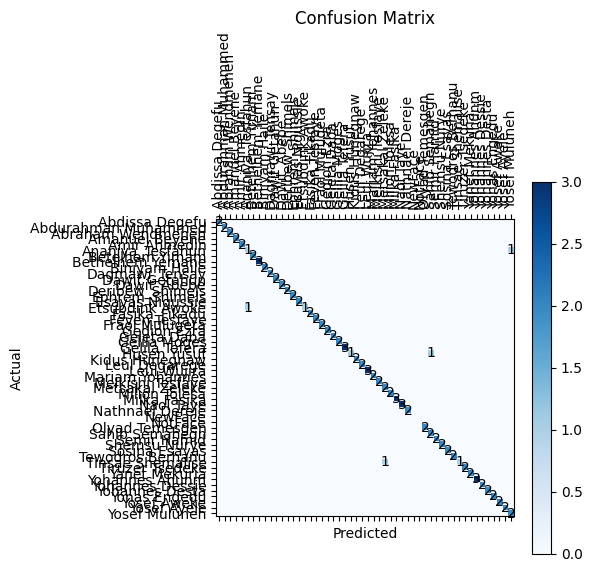

In [50]:
plt.matshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(range(len(student_names)), student_names, rotation=90)
plt.yticks(range(len(student_names)), student_names)

for i in range(len(student_names)):
    for j in range(len(student_names)):
        if cm[i, j] > 0:
            plt.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")            

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [51]:
accuracy = calc_accuracy(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.23%


In [12]:
from eigenface import EigenFaces

In [13]:
recognition_model = EigenFaces(num_components=100)

In [14]:
recognition_model.fit(x_train, y_train)

NameError: name 'x_train' is not defined

In [55]:
y_pred = recognition_model.transform(x_test)

In [56]:
calc_accuracy(y_test, y_pred)

0.9622641509433962

# Preprocessing the images first

In [15]:
from skimage import exposure
import cv2
import numpy as np


def resize_images(images, new_size=(250, 250)):        
    resized_images = [cv2.resize(image, new_size) for image in images]    
    return resized_images


def normalize_images(images):    
    normalized_images = [image / 255.0 for image in images]    
    return normalized_images


def apply_histogram_equalization(images):    
    equalized_images = [exposure.equalize_hist(image) for image in images]    

    return equalized_images


def apply_gaussian_blur(images, sigma=1.0):    
    blurred_images = [cv2.GaussianBlur(image, (5, 5), sigma) for image in images]    
    
    return blurred_images


def flatten(images):       
    flattened_images = [image.flatten() for image in images]
    return np.array(flattened_images)


def preprocess_images(images):
    images = resize_images(images)
    images = normalize_images(images)
    images = apply_histogram_equalization(images)    
    images = apply_gaussian_blur(images)
    images = flatten(images)
    return images


In [16]:
import os
import cv2

face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def preprocess_images(path=None, output_path=None, resize=(250, 250)):        

    if path is None:
        path = os.path.join(os.getcwd(), 'images')
    
    if output_path is None:
        output_path = os.path.join(os.getcwd(), 'preprocessed_images')

        
    os.makedirs(output_path, exist_ok=True)

    
    images = []
    students = []

    for student in os.listdir(path):
        student_path = os.path.join(path, student)                
        
        if os.path.isdir(student_path):   
            os.makedirs(os.path.join(output_path, student), exist_ok=True)         
        
            for image_name in os.listdir(student_path):
                image_path = os.path.join(student_path, image_name)
        
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path)
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    
                    faces = face_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
                    
                    if len(faces) == 0:
                        print(image_path)
                        continue

                    (x, y, w, h) = faces[0]
                    face_roi = gray_image[y:y+h, x:x+w]
                    
                    img = preprocess_images([face_roi])[0]                      

                    images.append(img)
                    students.append(student)

                    output_image_path = os.path.join(output_path, student, image_name)
                    cv2.imwrite(output_image_path, face_roi)

    return np.array(images), np.array(students)                                                             

In [17]:
# preprocess_images()

In [18]:
images, students = load_images('augmented_images', resize=(250, 250))

In [19]:
x_train, x_test, y_train, y_test = train_test_split(images, students, test_size=0.2, random_state=42, stratify=students)

In [32]:
import eigenface
from importlib import reload
reload(eigenface)
eigenface_recognizer = eigenface.EigenFaces(num_components=100)

In [33]:
eigenface_recognizer.fit(x_train, y_train)

In [34]:
y_pred = eigenface_recognizer.transform(x_test, log=True)

[('Husen Yusuf', 4)]
[('Yohannes Ahunm', 5)]
[('Dagmawi_Tensay', 5)]
[('Mariam Yohannes', 5)]
[('Husen Yusuf', 5)]
[('Naol Taye', 5)]
[('Bethelhem Yemane', 5)]
[('Yosef Aweke', 5)]
[('Biniyam Haile', 5)]
[('Tewodros Berhanu', 5)]
[('Abdissa Degefu', 5)]
[('Feven Tesfaye', 5)]
[('Gedion Ezra', 5)]
[('Nathnael Dereje', 5)]
[('Yosef Ayele', 5)]
[('Leul Degarege', 5)]
[('Amir Ahmedin', 5)]
[('Bethelhem Yemane', 5)]
[('Geleta Daba', 5)]
[('Dawit Getahun', 5)]
[('Olyad Temesgen', 5)]
[('Dawit_Abebe', 5)]
[('Milka Fasika', 5)]
[('Abraham Wendmeneh', 5)]
[('Dawit_Abebe', 5)]
[('Olyad Temesgen', 5)]
[('Yosef Aweke', 5)]
[('Leul Wujira', 5)]
[('Tinsae Shemalise', 5)]
[('Yonas Engedu', 5)]
[('Semir Hamid', 5)]
[('Deribew_Shimels', 5)]
[('Feven Tesfaye', 5)]
[('Leul Wujira', 5)]
[('Ananiya_Tesfahun', 5)]
[('Milka Fasika', 5)]
[('Yohannes Desta', 5)]
[('Leul Degarege', 5)]
[('Deribew_Shimels', 5)]
[('Ananiya_Tesfahun', 5)]
[('Kidus Hunegnaw', 5)]
[('Yanet Mekuria', 5)]
[('Amanuel Beyene', 5)]
[('Ge

In [35]:
calc_accuracy(y_test, y_pred)

1.0

In [31]:
import pickle

with open('models/eigenface_recognizer.pkl', 'wb') as f:
    pickle.dump(eigenface_recognizer, f)